# Notebook for Confidence Interval model
In this notebook we train a Linear Regression model to predict the Confidence Interval of our MSR Load Estimations. The model is trained on the predictions and their corresponding measurements of 65 MRIDs, of which 13 are held back for evaluation.

## Parameters
Parameters to use for the model

In [1]:
########
# Data #
########
ESTIMATIONS_FILE = 'estimations.csv'
MEASUREMENTS_FILE = 'measurements.csv'

#########
# MODEL #
#########

# Select which features to use for the model
FEATURES_TO_USE = ['hour', 'estimation']

# Mean and STD of estimation feature after min/max normalization
# These are used for standardization of the estimation feature, which allows for using a sigmoid transformation
# See generate_model_data() for how these values are calculated. These values are calculated on all available data.
ESTIMATION_MEAN = 0.33736
ESTIMATION_STD = 0.11137

##############
# EVALUATION #
##############
DAYS_TO_PLOT = 5
TEST_MRIDS = ['00bffd24-1f0b-586b-b353-4cea5ceaff1b',
'0c0ad75e-7c00-5393-8f79-03a1d11aadd0',
'1f226e09-3f9e-52e4-984c-c0749b9654d0',
'2af8dd36-5065-571f-aa75-038c7496942e',
'3208c09f-88b3-470a-b8c9-ac2f18b028b3',
'46928fb1-083e-520d-b3a5-57b9e1b5e1a2',
'5fdaa414-c47b-5eea-a9b3-71a5c720dd47',
'8ceaaff9-5406-5420-bf57-436f189a96ed',
'985f8460-2e08-5054-bd81-126d544cabd4',
'af895424-9a66-4695-bfa4-7cfaa8eac64f',
'd364be8b-cbee-56b1-8732-28b85f7dea4c',
'e6b10eef-6b87-4ce4-8186-c356b75e7fec',
'ffabbb9c-3d4c-543e-b6e6-80fadf3dea29']

#########
# DEBUG #
#########
DEBUG_LIST_ALL_MSR = False

## Import Packages
If packages not found, use `pip install pandas pyaml scikit-learn tqdm cufflinks seaborn plotly`

In [2]:
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

print(__version__)


5.11.0


In [4]:

import json
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import scipy.stats as stats
from sklearn.preprocessing import MinMaxScaler

import requests

from datetime import timedelta
import os
from glob import glob
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import datetime

import yaml
import collections
import joblib

## Loading data

In [5]:
data_dir = os.getcwd()
estimations = pd.read_csv(os.path.join(data_dir,ESTIMATIONS_FILE), index_col=0, parse_dates=True)
measurements = pd.read_csv(os.path.join(data_dir,MEASUREMENTS_FILE), index_col=0, parse_dates=True)

# How wrong are the estimations compared to the measurements at each point in time
errors = estimations - measurements

In [6]:
display(estimations.head())

,00bffd24-1f0b-586b-b353-4cea5ceaff1b,0c0ad75e-7c00-5393-8f79-03a1d11aadd0,133aaad0-7a96-5385-a436-42443c49a582,18001461-0c52-5caf-a1bf-dfe5284fa5cc,1af6b926-ad76-5af7-91a1-aac1f3fa6e31,1ec2e56f-4943-55cf-a2ce-27451edffd5f,1f226e09-3f9e-52e4-984c-c0749b9654d0,1f90f958-9825-5990-b41b-ea9e520a5337,206306f6-29c3-47f4-b9bc-1d0441c33289,206c710a-d76d-59f1-a51b-c8254ea6f344,...,d1f9f04a-7c0d-5b55-b57b-921fec720516,d1fbbe1c-6d3c-5511-866e-3efe95c8147e,d364be8b-cbee-56b1-8732-28b85f7dea4c,d4da0a9c-c97c-56e5-a38a-7f250438214e,e426bb2f-4ca6-51e3-8075-fd30ae23408b,e6b10eef-6b87-4ce4-8186-c356b75e7fec,f5f898a1-4712-52b5-b624-babd6d32ca72,f6433461-bbf7-5ac0-bc66-9ce557d6b082,fc78a31b-c8d7-4178-8b37-20e0c91db469,ffabbb9c-3d4c-543e-b6e6-80fadf3dea29
2022-07-01 00:00:00+00:00,9805.708,4600.8800,35530.860,50522.945,26740.584,13589.250,42996.277,15258.019,32436.195,42736.900,...,46995.168,528.36730,39127.582,9812.723,26986.646,45024.613,987.2827,24871.121,94467.420,25678.494
2022-07-01 00:15:00+00:00,9671.173,4518.0140,35242.664,54225.234,26247.533,13408.378,42291.965,11125.248,31978.166,41976.160,...,46162.227,522.27580,42779.440,9738.147,26575.822,48289.490,4975.1910,24503.602,97652.805,25327.348
2022-07-01 00:30:00+00:00,9563.938,4440.3994,34979.330,57863.770,29767.096,17238.390,41653.934,14989.037,31395.596,45346.984,...,45448.055,515.69403,42359.203,9659.160,26139.287,47705.414,8967.3490,24149.932,89031.300,24963.445
2022-07-01 00:45:00+00:00,9492.708,4375.6143,34891.540,49713.200,25343.236,13092.198,40947.844,10929.644,30845.629,40833.594,...,44842.445,511.21124,38059.973,9563.558,25650.094,51182.977,4961.5073,23905.229,84480.266,24673.096
2022-07-01 01:00:00+00:00,9415.038,4333.8486,34730.340,53566.800,25045.697,12990.553,40615.440,14862.185,30551.550,40412.332,...,44395.375,506.40063,41780.863,9565.954,25419.521,42845.812,4957.0894,23678.053,68093.840,24451.082


## Error distribution per time-of-day (hour) <a class="anchor" id="analysis-error-distr"></a>
Useful to see how the errors are distributed, and how this changes for each of the 24 hours of a day.

In [7]:
def get_mean_and_std_for_hour(data, hour):
    data_for_single_hour = data[(data.index.hour >= hour) & (data.index.hour < hour+1)]
    # Get all data points for that single hour for all MSRs into a single array
    # We loose information about the individual MRIDs
    distr = data_for_single_hour.to_numpy().flatten()
    
    # Return the mean and STD of all those data points
    return distr, distr.mean(), distr.std()

In [8]:
err_means = []
err_stds = []
for hour in range(24):
    _, mean, std = get_mean_and_std_for_hour(errors, hour)
    err_means.append(mean)
    err_stds.append(std)

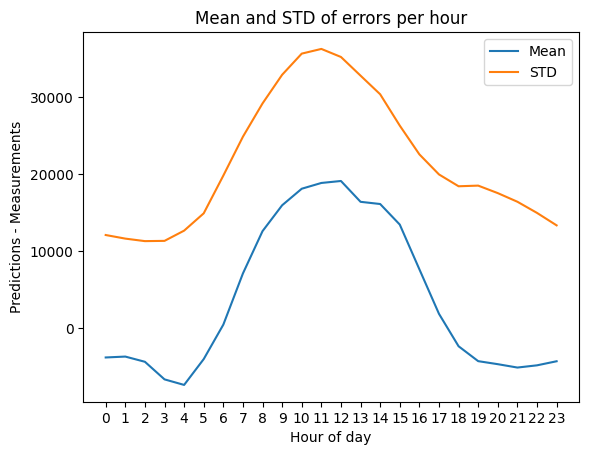

In [9]:
plt.plot(err_means, label="Mean")
plt.plot(err_stds, label="STD")
plt.xlabel("Hour of day")
plt.ylabel("Predictions - Measurements")
plt.title("Mean and STD of errors per hour")
plt.xticks(range(24))
plt.legend()
plt.show()

## Feature transformations <a class="anchor" id="feature-transformations"></a>
Linearlization of features by applying transformations to each feature. This is very important for linear regression.

In [10]:
# Feature transformations
def transform_hour(hour):
    return np.sin((hour*np.pi*2)-np.pi/2)

def transform_log(x):
    return np.log(x+0.00001)

def standardize(x):
    return (x - x.mean())/(x.std())

def sigmoid(x):
    return 1/(1 + np.exp(-x))

In [11]:
def apply_all_transformations(data_input):
    data = data_input.copy()
    data['hour'] = transform_hour(data['hour'])
    data['estimation'] = sigmoid((data['estimation'] - ESTIMATION_MEAN)/ESTIMATION_STD)
    return data

## Creating the model <a class="anchor" id="creating-models"></a>


In [12]:
def fit_linreg_model(data):
    # Train the linear regression model 
    return LinearRegression().fit(data[FEATURES_TO_USE], data[['mean', 'STD']])

#### Preparing input data for the models
Including label creation.

Applies min-max scaling as well, and returns the scaler so it can be applied on other data

In [13]:
# Returns dataframe with input for model plus the output labels, and the scaler used to min-max normalize the input
def generate_model_data(measured, estimated, do_transformations=True):
    
    # Generates the mean and STD label for a given MRID-hour combination
    def get_label_for_mrid_and_hour(data, mrid, hour):
        distr = data[mrid][data.index.hour == hour]
        #distr.plot.hist()
        #plt.show()
        return distr.mean(), distr.std()
    
    differences = estimated - measured
    
    # Build dataframe as list of dicts
    # Note that this is quite inefficient and that it can be done faster using df.melt and df.pivot
    rows_list = []
    for mrid in tqdm(estimated.columns, desc = 'Building data for MRIDs'):
        
        for timestamp, estimation in estimated[mrid].items():
            mean, std = get_label_for_mrid_and_hour(differences, mrid, timestamp.hour)
            row_dict = {
                "MRID": mrid,
                "hour": timestamp.hour,
                "estimation": estimation,
                "mean": mean,
                "STD": std
            }
            
            rows_list.append(row_dict)
            
    # Normalize features
    scaler = MinMaxScaler()
    return_df = pd.DataFrame(rows_list)
    return_df[FEATURES_TO_USE] = scaler.fit_transform(return_df[FEATURES_TO_USE])
    
    # Code that was used to calculate the ESTIMATION_MEAN and ESTIMATION_STD
    #print("Estimation mean value:", return_df['estimation'].mean())
    #print("Estimation STD value:", return_df['estimation'].std())
    
    # Apply transformations to the features
    if do_transformations:
        return_df = apply_all_transformations(return_df)
    
    return return_df, scaler

## Training the model and generating results

In [14]:
# Generate train data, keep out TEST_MRIDs for evaluation
train_measurements = measurements.drop(TEST_MRIDS,axis=1)
train_estimations = estimations.drop(TEST_MRIDS,axis=1)

# Generate data for model
print("Generating train dataframe")
train_df, scaler = generate_model_data(train_measurements, train_estimations)

# Train model
print("Training LinReg model")
linreg_model = fit_linreg_model(train_df)

Generating train dataframe



Training LinReg model


## Evaluation <a class="anchor" id="eval-functions"></a>


### Plot single MRIDs

In [12]:
def plot_single_mrid(df_single_mrid, mrid, days_to_plot=31):
    
    
    fig = go.Figure()
    fig.update_layout(template="plotly_white", title=mrid, xaxis_title="Time", yaxis_title="Load")
    
    # Lower bound
    fig.add_trace(go.Scatter(x=df_single_mrid.index[:24*4*days_to_plot],
                             y=df_single_mrid['lower_bound'].iloc[:24*4*days_to_plot],
                             fill=None,
                             mode='lines',
                             line_color='orange',
                             name="Lower bound",
                             showlegend=False,
                             legendgroup="bound"
                            )
                 )
    # Upper bound
    fig.add_trace(go.Scatter(x=df_single_mrid.index[:24*4*days_to_plot],
                             y=df_single_mrid['upper_bound'].iloc[:24*4*days_to_plot],
                             fill='tonexty', # fill area between lower and upper bound
                             opacity=0.1,
                             mode='lines',
                             line_color='orange',
                             name="Upper/lower bound",
                             legendgroup="bound"
                            )
                 )
    # Estimations
    fig.add_trace(go.Scatter(x=df_single_mrid.index[:24*4*days_to_plot],
                             y=df_single_mrid['estimation'].iloc[:24*4*days_to_plot],
                             mode="markers",
                             marker=dict(
                                 color='blue',
                                 size=5,
                             ),
                             name="Estimations"
                            )
                 )
    # LS Measurements background line (All)
    fig.add_trace(go.Scatter(x=df_single_mrid.index[:24*4*days_to_plot],
                             y=df_single_mrid['measurement'].iloc[:24*4*days_to_plot],
                             mode="lines",
                             line_color='grey',
                             opacity=0.75,
                             name="Measurement line"
                            )
                 )
    # LS Measurements (All)
    fig.add_trace(go.Scatter(x=df_single_mrid.index[:24*4*days_to_plot],
                             y=df_single_mrid['measurement'].iloc[:24*4*days_to_plot],
                             mode="markers",
                             marker=dict(
                                 color='green',
                                 size=5,
                             ),
                             name="Measurements"
                            )
                 )
    # LS Measurements outside bounds
    fig.add_trace(
        go.Scatter(
            x = df_single_mrid['measurement'].iloc[:24*4*days_to_plot][(
                (df_single_mrid['measurement']>df_single_mrid['upper_bound'])|
                (df_single_mrid['measurement']<df_single_mrid['lower_bound'])
                )].index,
            y = df_single_mrid['measurement'].iloc[:24*4*days_to_plot][(
                (df_single_mrid['measurement']>df_single_mrid['upper_bound'])|
                (df_single_mrid['measurement']<df_single_mrid['lower_bound'])
                )],
            mode = "markers",
            marker = dict(
                color='red',
                size=5,
                ),
            name = "Measurements outside bounds"
            )
        )
    
    fig.show()

In [13]:
# Test a single MRID using given model
def test_single_mrid_model(mrid, model, do_plot=True, do_display=False, days_to_plot=31, symmetric=False):
    # Combine measurements and estimations for single MRID into one Dataframe
    df_single_mrid = pd.DataFrame().assign(measurement=measurements[mrid], estimation=estimations[mrid])
    
    # Add column with features used by the model
    df_single_mrid['hour'] = df_single_mrid.index.hour
    
    # Normalize
    df_single_mrid_normalized = df_single_mrid.copy()
    df_single_mrid_normalized[FEATURES_TO_USE] = scaler.transform(df_single_mrid_normalized[FEATURES_TO_USE])
    
    # Transform features
    df_single_mrid_normalized = apply_all_transformations(df_single_mrid_normalized)
    
    # Make predictions for mean and STD using the model
    predictions = model.predict(df_single_mrid_normalized[FEATURES_TO_USE])
    
    # Add predictions to dataframe (transpose is needed to align with dataframe)
    df_single_mrid['mean'], df_single_mrid['STD'] = predictions.T
    
    # Calculate confidence interval using estimation, mean and std
    # upper bound = (est - mean) + std*3
    # upper bound = (est - mean) - std*3
    if symmetric:
        df_single_mrid['upper_bound'] = (df_single_mrid['estimation']) + df_single_mrid['STD']*3
        df_single_mrid['lower_bound'] = (df_single_mrid['estimation']) - df_single_mrid['STD']*3
    else:
        df_single_mrid['upper_bound'] = (df_single_mrid['estimation'] - df_single_mrid['mean']) + df_single_mrid['STD']*3
        df_single_mrid['lower_bound'] = (df_single_mrid['estimation'] - df_single_mrid['mean']) - df_single_mrid['STD']*3
    
    # Mark if points fall outside the confidence interval
    df_single_mrid['outside_interval'] = (
        (df_single_mrid.measurement > df_single_mrid.upper_bound) | 
        (df_single_mrid.measurement < df_single_mrid.lower_bound)
    )
    
    if do_plot:
        plot_single_mrid(df_single_mrid, mrid, days_to_plot=days_to_plot)
        
    return df_single_mrid

In [14]:
# Plot held out test set
for mrid in TEST_MRIDS:
    test_single_mrid_model(mrid, linreg_model, do_plot=True, days_to_plot=DAYS_TO_PLOT)